In [1]:
import itertools
import os
import pickle
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io
from skimage import exposure
from skimage.registration import phase_cross_correlation

In [2]:
# import matplotlib.pyplot as plt  
# plt.style.use('dark_background')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

from config import *

In [5]:
csv_file = data_meta / "all_info.csv"

# Read dataframe containing images information
df = pd.read_csv(csv_file)

In [6]:
df

Cycle Condition   Z_stack Channel                 Marker  \
0    2seg       Fw1         1     CH1                   DAPI   
1    2seg       Fw1         1     CH3             Phalloidin   
2    2seg       Fw1         1     CH4                    WGA   
3    2seg       Fw1         2     CH1                   DAPI   
4    2seg       Fw1         2     CH3             Phalloidin   
..    ...       ...       ...     ...                    ...   
290  CycE       Fw3  Combined     CH3                EMMPRIN   
291  CycE       Fw3  Combined     CH4                  WNT-1   
292  DKK1       Fw3  Combined     CH1                   DAPI   
293  DKK1       Fw3  Combined     CH2  Non-phospho-B-catenin   
294  DKK1       Fw3  Combined     CH4                   DKK1   

                                                  Path  \
0    y:\coskun-lab\Thomas\Spatial signaling pathway...   
1    y:\coskun-lab\Thomas\Spatial signaling pathway...   
2    y:\coskun-lab\Thomas\Spatial signaling pathway...   
3    y:\coskun-lab\Thomas\Spatial signaling pathway...   
4    y:\coskun-lab\Thomas\Spatial signaling pathway...   
..                                                 ...   
290                                                NaN   
291                                                NaN   
292                                                NaN   
293                                                NaN   
294                                                NaN   

                                        Path_corrected  
0    y:\coskun-lab\Thomas\Spatial signaling pathway...  
1    y:\coskun-lab\Thomas\Spatial signaling pathway...  
2    y:\coskun-lab\Thomas\Spatial signaling pathway...  
3    y:\coskun-lab\Thomas\Spatial signaling pathway...  
4    y:\coskun-lab\Thomas\Spatial signaling pathway...  
..                                                 ...  
290  y:\coskun-lab\Thomas\Spatial signaling pathway...  
291  y:\coskun-lab\Thomas\Spatial signaling pathway...  
292  y:\coskun-lab\Thomas\Spatial signaling pathway...  
293  y:\coskun-lab\Thomas\Spatial signaling pathway...  
294  y:\coskun-lab\Thomas\Spatial signaling pathway...  

[295 rows x 7 columns]

# Get registration result

In [7]:
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

def create_transparent_cmap(cmap):
    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))

    # Set alpha
    my_cmap[:, -1] = np.linspace(0, 1, cmap.N)

    # Create new colormap
    my_cmap = ListedColormap(my_cmap)

    return my_cmap

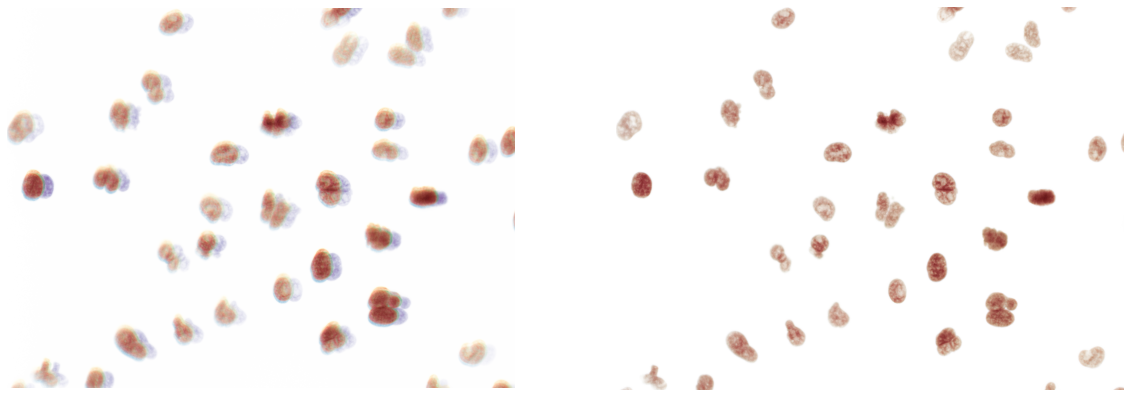

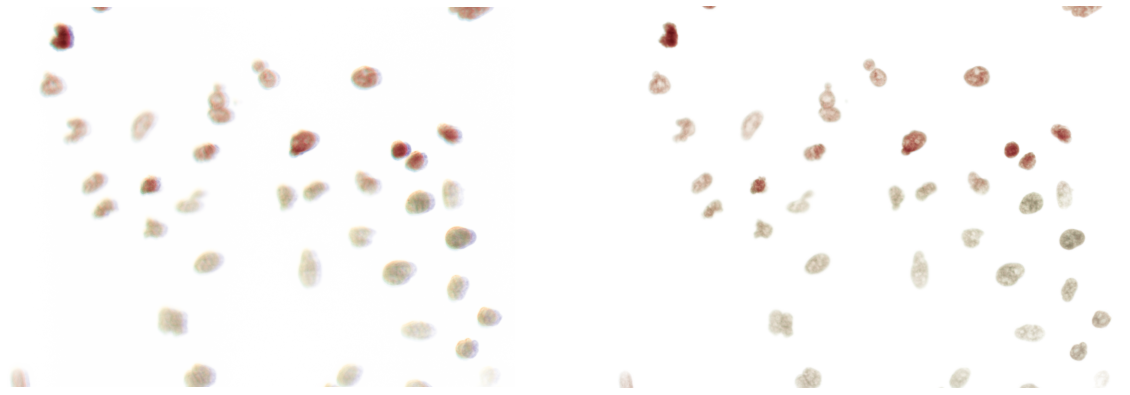

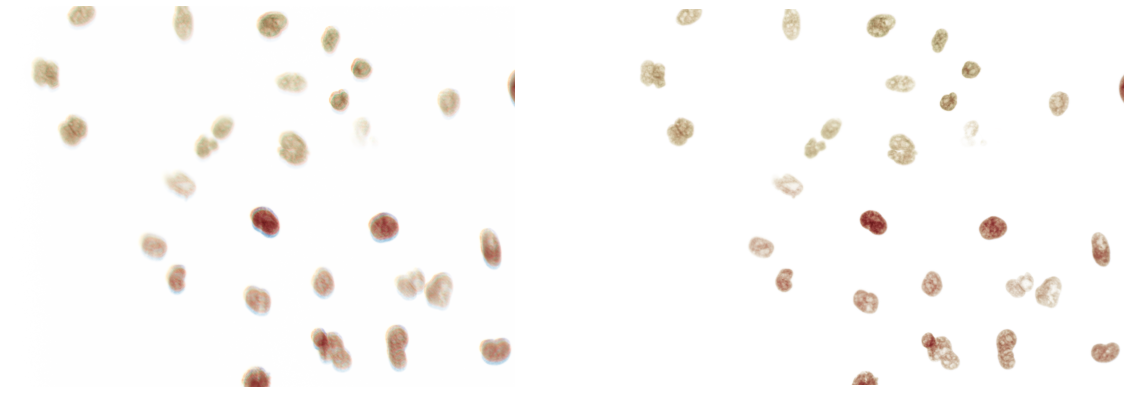

In [8]:
# Get shift between cycle
cycles = df.Cycle.unique()
conditions = df.Condition.unique()

colors = [pl.cm.YlOrBr, pl.cm.Blues, pl.cm.Purples, pl.cm.Greens, pl.cm.Reds]
my_cmaps = [create_transparent_cmap(cmap) for cmap in colors]

for condition in conditions:
    df_subset = df[(df.Condition == condition) & (df.Channel == "CH1")]

    fig, axs = plt.subplots(1, 2)
    for idx, cycle in enumerate(cycles):
        temp = df_subset[df_subset.Cycle == cycle]
        img_dapi = skimage.io.imread(temp[temp.Z_stack == "1"].Path.item())
        img_dapi_corrected = skimage.io.imread(
            temp[temp.Z_stack == "1"].Path_corrected.item()
        )

        axs[0].imshow(img_dapi, cmap=my_cmaps[idx], alpha=0.8)
        axs[1].imshow(img_dapi_corrected, cmap=my_cmaps[idx], alpha=0.8)

    axs[0].axis("off")
    axs[1].axis("off")

    fig.set_size_inches(20, 40)
#     fig.savefig(condition+'.png', bbox_inches='tight', dpi=100)
    plt.show()

# Multicolor overlay

In [9]:
DEFAULT_CHANNELS = (1, 2, 3)

RGB_MAP = {
    1: {"rgb": np.array([0, 0, 255]), "range": [0, 255]},
    2: {"rgb": np.array([255, 51, 51]), "range": [0, 50]},
    3: {"rgb": np.array([51, 255, 51]), "range": [0, 150]},
    4: {"rgb": np.array([153, 51, 255]), "range": [0, 50]},
}


def convert_to_rgb(t, channels=DEFAULT_CHANNELS, vmax=255, rgb_map=RGB_MAP):
    """
    Converts and returns the image data as RGB image
    Parameters
    ----------
    t : np.ndarray
        original image data
    channels : list of int
        channels to include
    vmax : int
        the max value used for scaling
    rgb_map : dict
        the color mapping for each channel
        See rxrx.io.RGB_MAP to see what the defaults are.
    Returns
    -------
    np.ndarray the image data of the site as RGB channels
    """
    dim1, dim2, _ = t.shape
    colored_channels = []
    for i, channel in enumerate(channels):
        x = (t[:, :, channel - 1] / vmax) / (
            (rgb_map[channel]["range"][1] - rgb_map[channel]["range"][0]) / 255
        ) + rgb_map[channel]["range"][0] / 255
        x = np.where(x > 1.0, 1.0, x)
        x_rgb = np.array(
            np.outer(x, rgb_map[channel]["rgb"]).reshape(dim1, dim2, 3), dtype=int
        )
        colored_channels.append(x_rgb)
    im = np.array(np.array(colored_channels).sum(axis=0), dtype=int)
    im = np.where(im > 255, 255, im)
    im = im.astype(np.uint8)
    return im

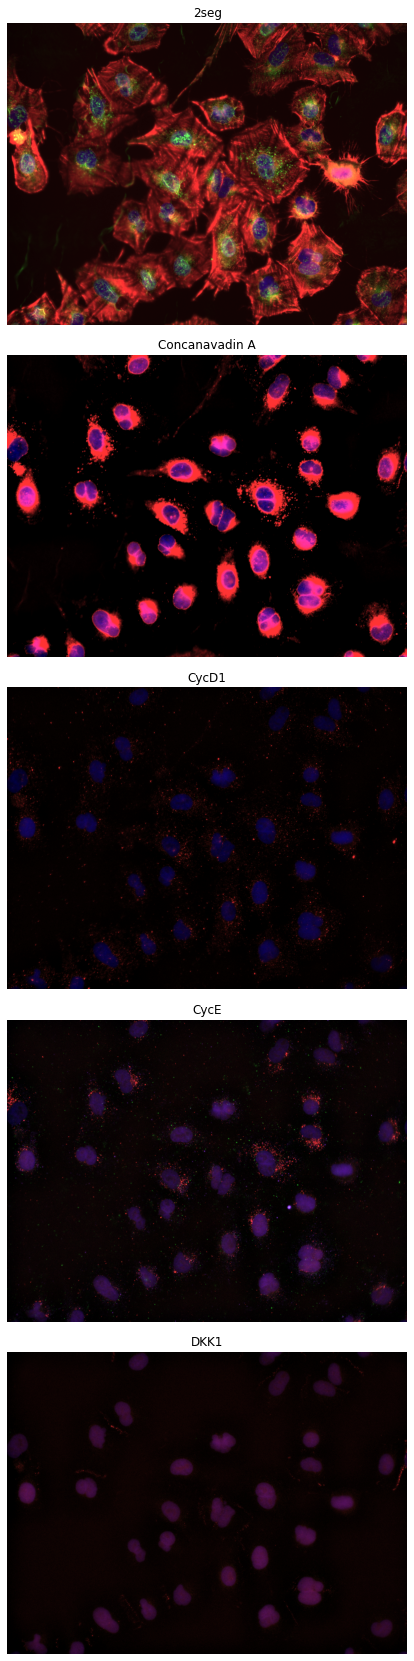

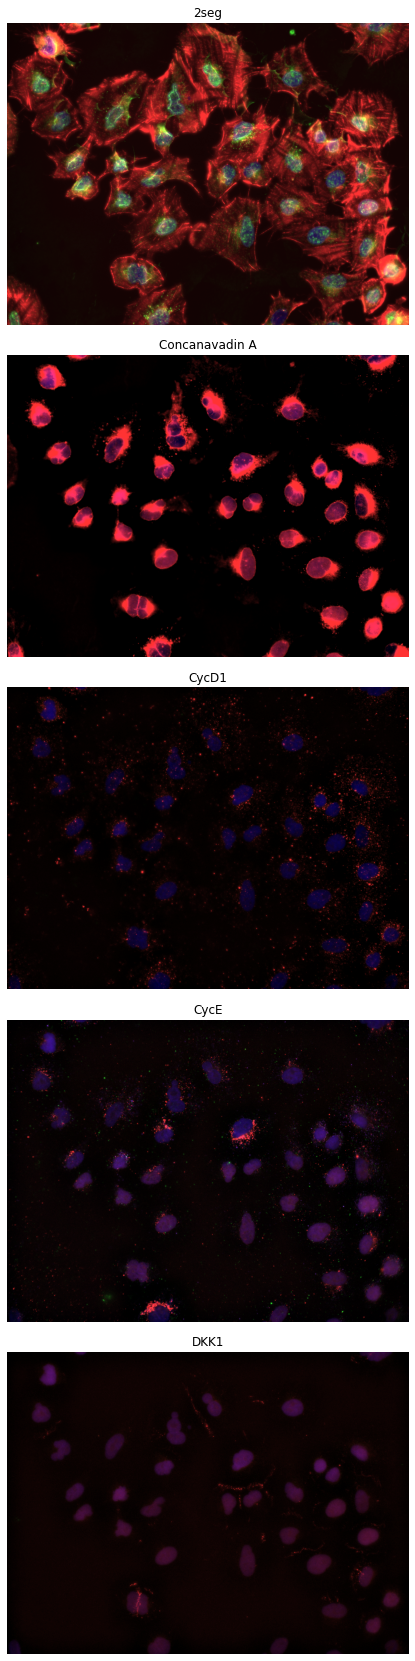

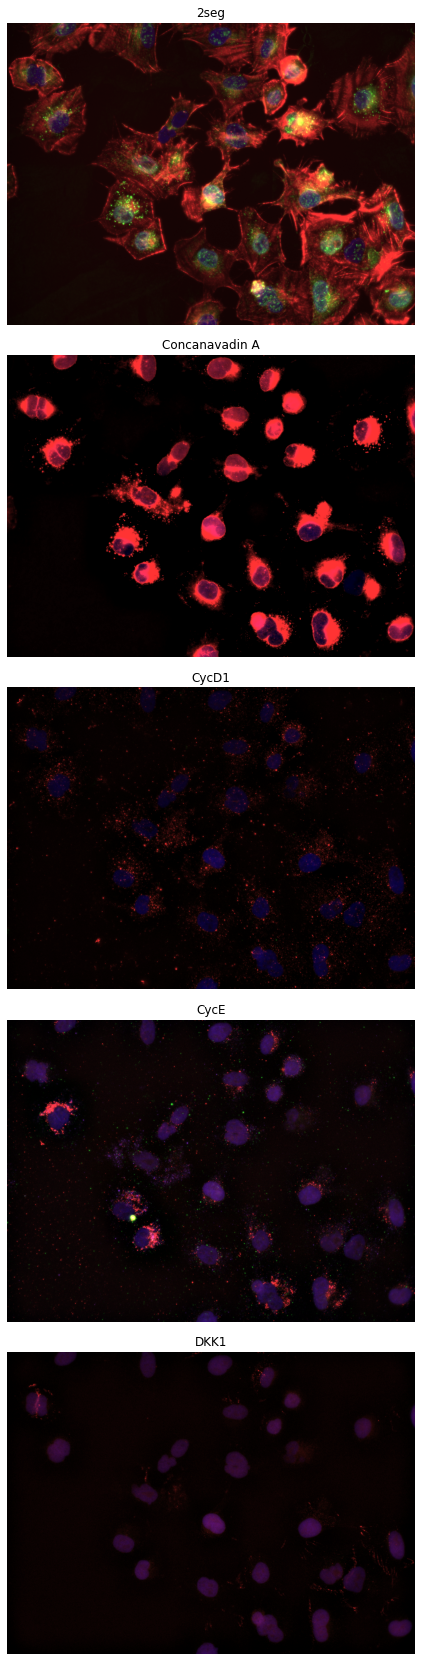

In [10]:
# Get shift between cycle
cycles = df.Cycle.unique()
conditions = df.Condition.unique()

for condition in conditions:
    df_subset = df[(df.Condition == condition) & (df.Z_stack == "Combined")]

    fig, axs = plt.subplots(5, 1, figsize=(8, 30))
    for idx, cycle in enumerate(cycles):
        temp = df_subset[df_subset.Cycle == cycle]
        data = None
        for row in temp.itertuples():
            img = skimage.io.imread(row.Path_corrected)
            if not data is None:
                data = np.concatenate((data, img[:, :, np.newaxis]), axis=2)
            else:
                data = img[:, :, np.newaxis]
        channel = (i for i in range(1, len(data[0][0]) + 1))
        #         img = convert_to_rgb(exposure.rescale_intensity(data), channels=channel ,vmax=65536)
        img = convert_to_rgb(exposure.adjust_log(data, 1), channels=channel, vmax=65536)
        axs[idx].imshow(img)
        axs[idx].axis("off")
        axs[idx].title.set_text(cycle)
    plt.subplots_adjust(wspace=0, hspace=0.1)
#     fig.savefig(condition+'_overlay.png', bbox_inches='tight')
    plt.show()

# Multiplex single image overlay

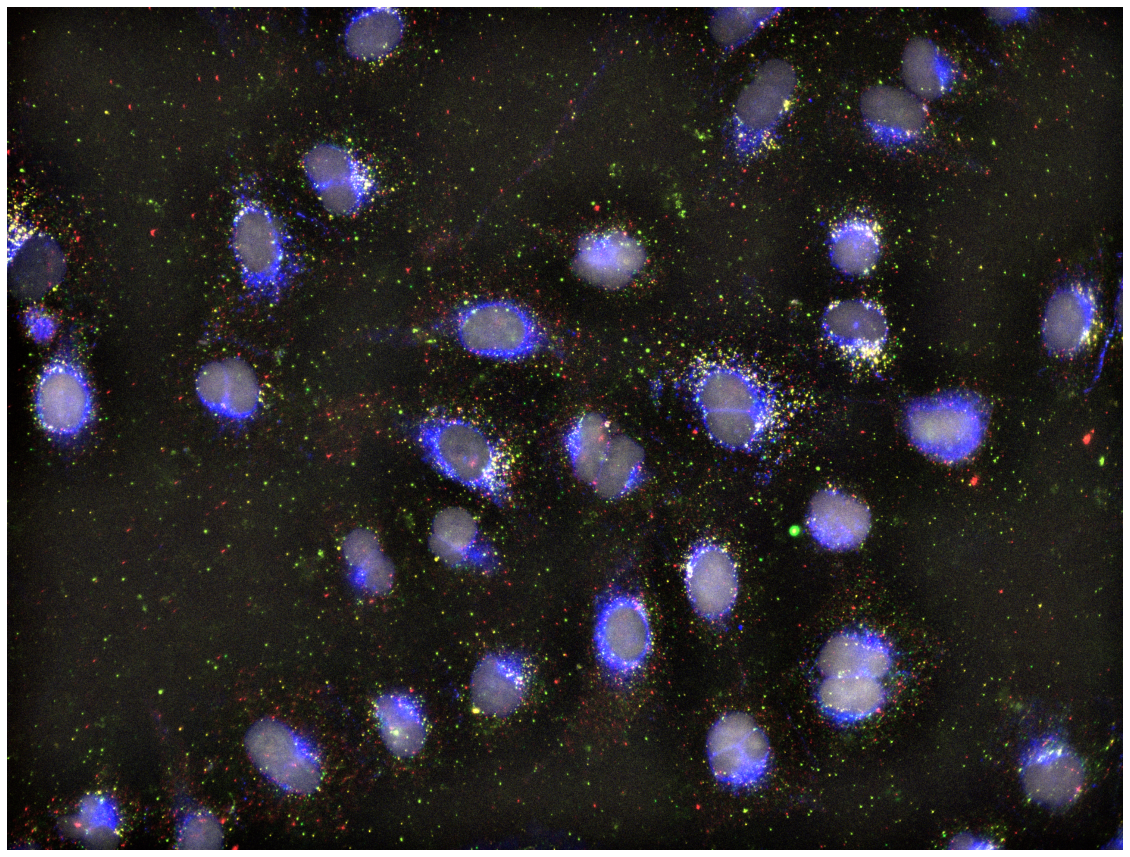

In [16]:
RGB_MAP = {
    1: {"rgb": np.array([0, 0, 255]), "range": [0, 255]},
    2: {"rgb": np.array([255, 51, 51]), "range": [0, 50]},
    3: {"rgb": np.array([255, 153, 51]), "range": [0, 50]},
    4: {"rgb": np.array([255, 255, 51]), "range": [0, 50]},
    5: {"rgb": np.array([153, 255, 51]), "range": [0, 50]},
    6: {"rgb": np.array([51, 255, 51]), "range": [0, 50]},
    7: {"rgb": np.array([51, 51, 255]), "range": [0, 50]},
    8: {"rgb": np.array([153, 51, 255]), "range": [0, 50]},
}

df_subset = df[(df.Condition == conditions[0]) & (df.Z_stack == "Combined")]

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
data = None
for idx, cycle in enumerate(cycles[1:]):
    temp = df_subset[df_subset.Cycle == cycle]
    for row in temp.itertuples():
        if row.Marker != 'DAPI':
            img = skimage.io.imread(row.Path_corrected)
            if not data is None:
                data = np.concatenate((data, img[:, :, np.newaxis]), axis=2)
            else:
                data = img[:, :, np.newaxis]
    channel = (i for i in range(1, len(data[0][0]) + 1))
img = convert_to_rgb(data, channels=channel, rgb_map=RGB_MAP, vmax=35536)
ax.imshow(img)
ax.axis('off')
fig.savefig('multiplex_overlay.png', bbox_inches='tight', dpi=100)
plt.show()